# Assignment 08: 
# Text Mining using Dimensionality Reduction Methods [_/100 Marks]

### Follow These Instructions

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.



#### In this assignment, we will study apply dimensionality reduction methods to improve our understanding of text data and to predict the sentiment of a set of texts. The dataset for this assignment comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. This application of data science is called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis) and it is widely used across many fields to get automated feedback when text opinions are expressed.



---

In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1 [ / 14 marks]

The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. Import the data and use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords. In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [2]:
# Load the data [ /1 marks]

df = pd.read_csv('Reviews_sample.csv')

# Display the first 5 rows [ /1 marks]

df.head(5)

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [3]:
# Defining the TfIDFTransformer [ /4 marks]

# From Lab 8

TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # Eliminate accents and special characters
                      stop_words='english', # Eliminates stop words.
                      min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                      max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                      sublinear_tf=True # Use sublinear weights (softplus), i.e., replace tf with 1 + log(tf)
                      )

X = df['text']
y = df['label']


# Train/test split [ /2 marks]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

# Calculate the Tf-Idf transform [ /4 marks]
TfIDF_train = TfIDFTransformer.fit_transform(x_train)
TfIDF_test  = TfIDFTransformer.transform(x_test)

TfIDF_train = TfIDF_train.toarray()
TfIDF_test  = TfIDF_test.toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
# Print the number of indices [ /2 marks]
word_index = TfIDFTransformer.get_feature_names_out()

len(word_index)

64

### Question 1.2 [ / 12 marks]
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the text reviews. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts/components.

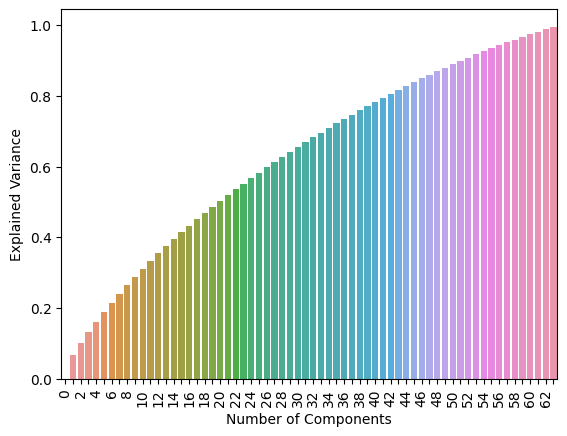

In [5]:
# Apply PCA on training data and get the explained variance [ / 4 marks]

# From Lab 8

n = len(TfIDFTransformer.get_feature_names_out())
nPCA = PCA(n_components = n, svd_solver = 'full')

nPCA.fit(TfIDF_train)

variances = nPCA.explained_variance_ratio_

total_vars = []

for i in range(len(variances)):
    total_vars.append(sum(variances[:i]))


# Plotting explained variance with number of concepts [ / 4 marks]

ax = sns.barplot(x = np.arange(0, n, 1), y = total_vars, width=0.8)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel = "Number of Components", ylabel = "Explained Variance")

for index, label in enumerate(ax.get_xticklabels()):
   if index % 2 == 0:
      label.set_visible(True)
   else:
      label.set_visible(False)

**Written Question:** Exactly how many concepts/components do we need to correctly explain at least 80% of the data? [ /4 marks]


In [6]:
# To get the exact index where the variance is above 80% [ / 4 marks]

idx = np.searchsorted(total_vars, 0.8)
        
print(f"We need {idx} components to get an explained variance of at least 80%")

We need 42 components to get an explained variance of at least 80%


**Your Answer:** 

### Question 1.3 [ / 14 marks]

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [7]:
# Explained variance [ / 2 marks]
print('The first three components explain %.2f%% of the variance.' % (total_vars[3]*100))

The first three components explain 13.22% of the variance.


In [8]:
# Get 10 most important words for each component [ / 4 marks]

component1 = word_index[np.argpartition(abs(nPCA.components_[0, :]), -10)][-10:]
component2 = word_index[np.argpartition(abs(nPCA.components_[1, :]), -10)][-10:]
component3 = word_index[np.argpartition(abs(nPCA.components_[2, :]), -10)][-10:]

In [9]:
# Words for concept 1 [ / 2 marks]

component1

array(['love', 'bought', 'just', 'written', 'buy', 'book', 'product',
       'read', 'reading', 'movie'], dtype=object)

In [10]:
# Words for concept 2 [ / 2 marks]

component2

array(['story', 'good', 'bad', 'great', 'worst', 'love', 'don', 'movie',
       'product', 'like'], dtype=object)

In [11]:
# Words for concept 3 [ / 2 marks]

component3

array(['little', 'day', 'wear', 'product', 'love', 'buy', 'movie',
       'great', 'good', 'time'], dtype=object)


**Written Question:** What is the cumulative variance explained by these three concepts? What would you name each of these concepts? [ / 2 marks]

*Hint: If in a concept you would get the words 'dog', 'cat', 'fish' as the most important ones, you could name the concept 'animals' or 'pets'.*

**Your answer:** The cumulative explained variance is 14.31%. I would say that concept 1 relates to "writing of the movie" or "advertising", concept 2 relates to "bad movies", and concept 3 relates to "good movies".

### Question 1.4 [ / 8 marks]

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the cases. Identify positive and negative cases by colouring points with different sentiments with different colours.


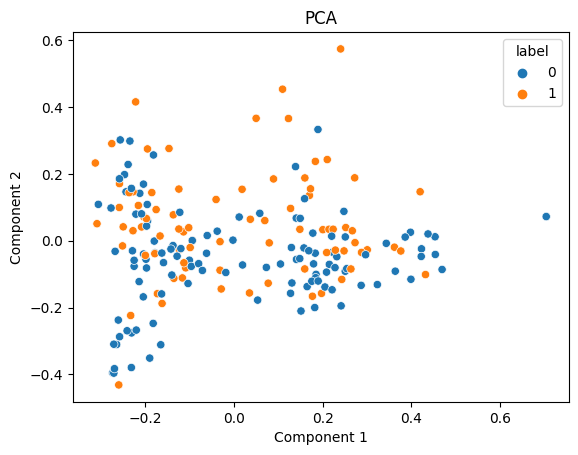

In [12]:
# Apply PCA to the test dataset [ / 2 marks]

Z = nPCA.transform(TfIDF_test)[:, 0:2]

# Plot the two different set of points with different markers and labels [ /4 marks]

sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=y_test)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA")
plt.show()

**Written Question:** What can we say about where the positive and negative cases lie in our plot? Could we use these concepts to discriminate positive and negative cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer:** The positive cases are way more scattered and they are mostly located above the negative ones. We cannot use the first two components to discriminate positive and negative cases since a large overlap can be seen for both cases where second component is between -0.2 and 0.

### Question  1.5 [ / 18 marks]

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*


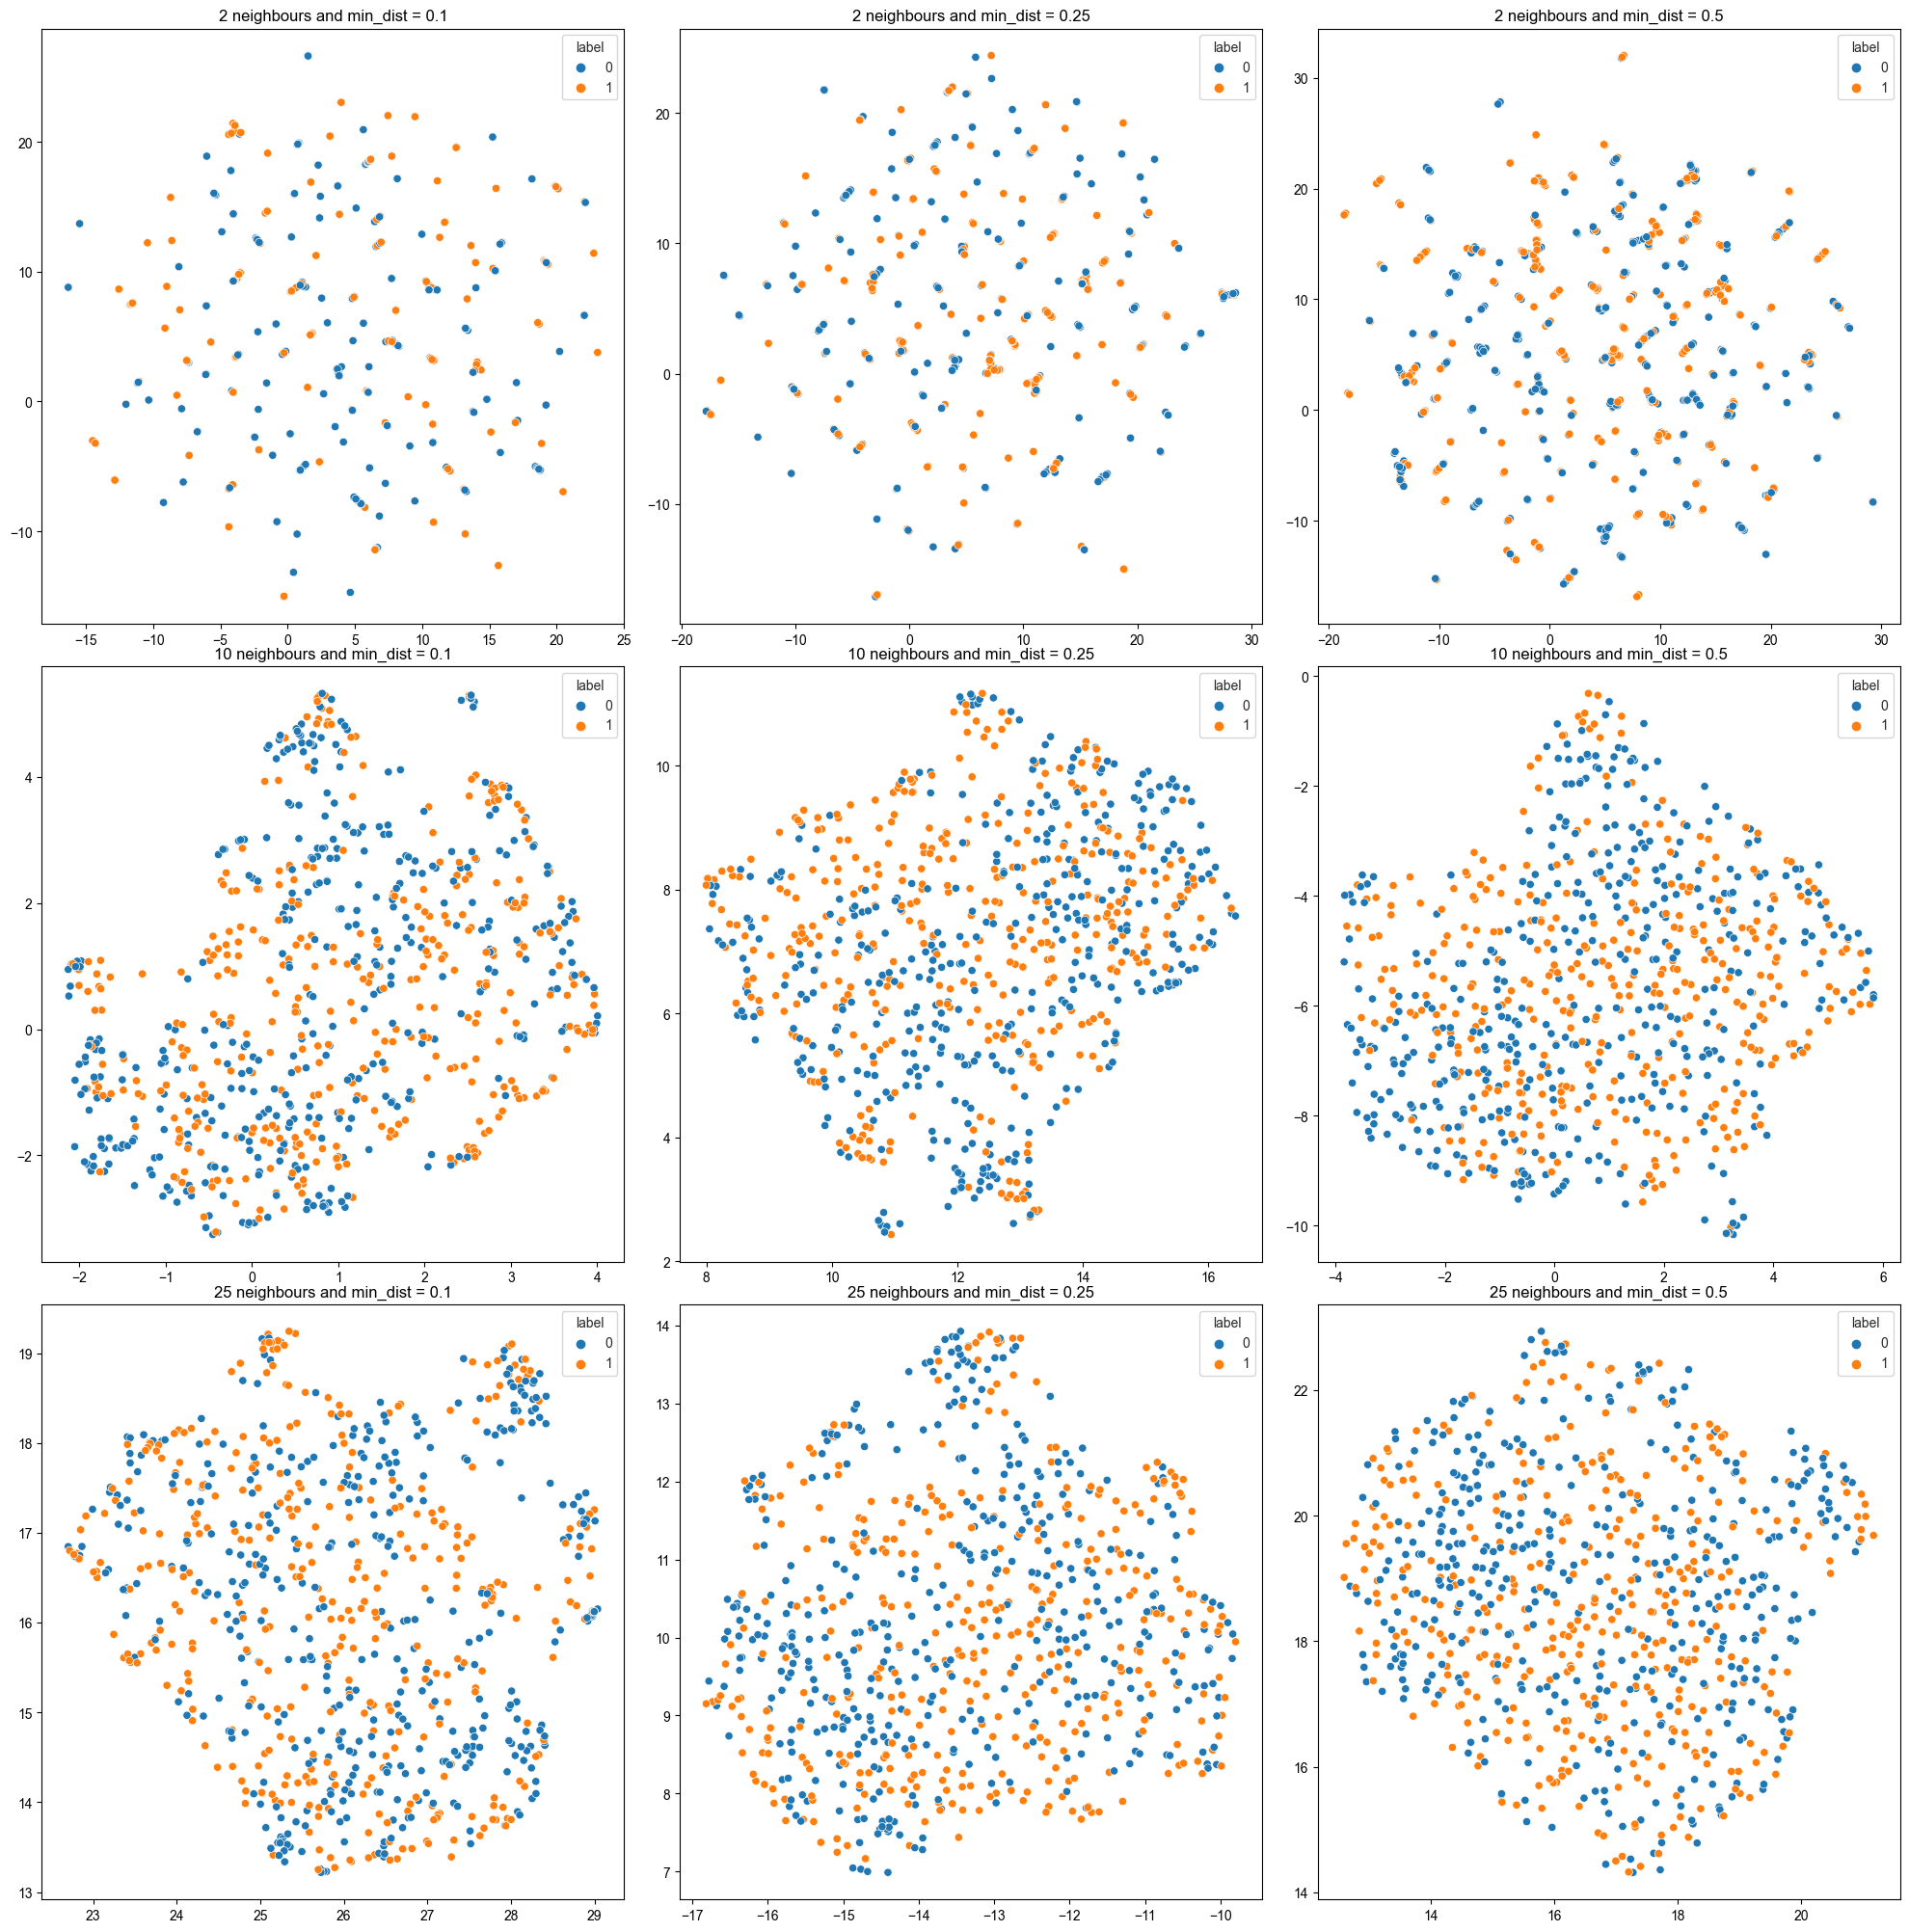

In [13]:
# Set parameters
fig, axs = plt.subplots(3, 3, figsize=(20,20))
n_neighbors=[2, 10, 25]
min_dist=[0.1, 0.25, 0.5]
fig.tight_layout()
sns.set_style('white')

# Create UMAP and plots [ / 10 marks]


for i in range(3):
    for j in range(3):
        reducer = umap.UMAP(n_neighbors=n_neighbors[i],           # Number of neareast neighbours to use. 
                        n_components=2,              # Number of components. UMAP is robust to larger values
                        metric='cosine',             # Metric to use.
                        n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                        min_dist=min_dist[j],                  # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                        low_memory=False,             # Run slower, but with less memory.
                        n_jobs=-1,
                        init='random',
                        verbose=False                # Verbosity
                       )
        reducer.fit(TfIDF_train)
        
        UMAP_embedding = reducer.transform(TfIDF_train)
        figure = sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=y_train, ax=axs[i][j]).set(
                                title= str(n_neighbors[i]) + " neighbours and min_dist = " + str(min_dist[j]))

**Written Question:** Which paramter would you choose? [ / 2 makrs]

**Your Answer:** We want to choose the parameters which generate the most separation between the labels. It looks like choose n_neighbors = 10 and min_dist = 0.25 accomplishes that, but this is subjective.

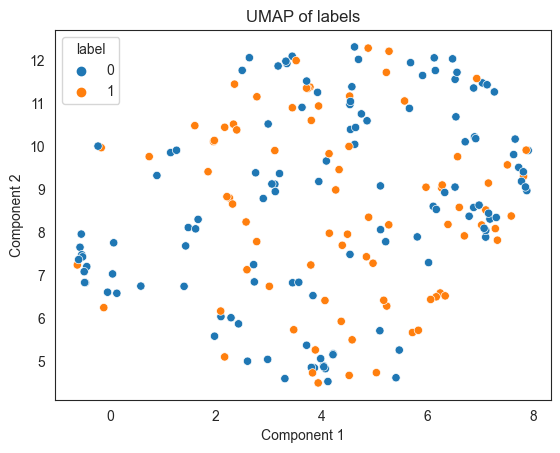

In [14]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]

reducer = umap.UMAP(n_neighbors=10,           # Number of neareast neighbours to use. 
                        n_components=2,              # Number of components. UMAP is robust to larger values
                        metric='cosine',             # Metric to use.
                        n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                        min_dist=0.25,                  # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                        spread=1.0,                  # Scale to combine with min_dist
                        low_memory=False,             # Run slower, but with less memory.
                        n_jobs=-1,
                        init='random',
                        verbose=False                # Verbosity
                       )

reducer.fit(TfIDF_train)

UMAP_embedding = reducer.transform(TfIDF_test)


# Create plot [ /2 marks]

sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=y_test)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("UMAP of labels")
plt.show()



**Written Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer:** UMAP creates much sparser class divisions (i.e., it classifies the points better). The PCA plot is fairly dense, whereas this is very spread out. So, there should be a nonlinear pattern.

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 [ /8 marks]
Train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

0.728


Text(0, 0.5, 'TP Rate')

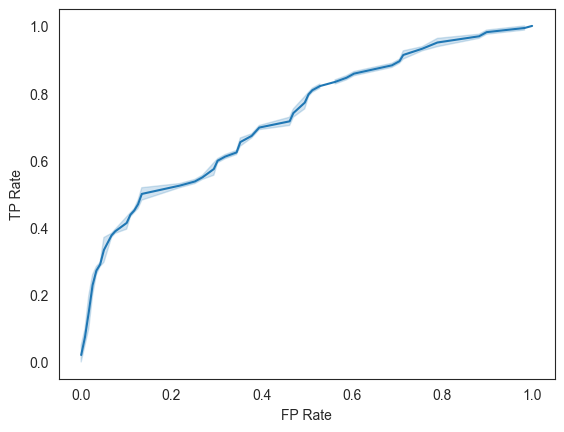

In [15]:
from sklearn.metrics import auc

# Train and test using model LogisticRegressionCV [ /4 marks]

log_model = LogisticRegressionCV(cv=5, random_state=seed, n_jobs=-1)

log_model.fit(TfIDF_train, y_train)

# Plot ROC curve and compute AUC score [ /4 marks]

probs = log_model.predict_proba(TfIDF_test)

fpr1, tpr1, _ = roc_curve(y_test, probs[:,1], pos_label=log_model.classes_[1]) 

print(auc(fpr1,tpr1).round(3))

# Create and show the plot

ax =sns.lineplot(x=fpr1,y=tpr1)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")

### Question 2.2 [ /12 marks]
Train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

0.7


Text(0, 0.5, 'TP Rate')

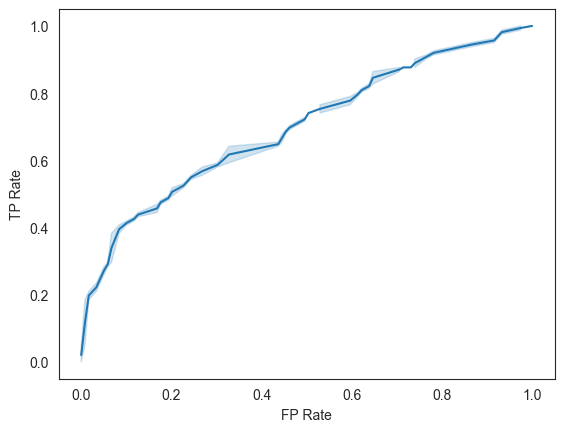

In [16]:
# Apply SVD first [ / 4 marks]

# From Lab 8

decomposition = TruncatedSVD(n_components=10, random_state = seed)

decomposition.fit(TfIDF_train)

Xtrain = decomposition.transform(TfIDF_train)
Xtest = decomposition.transform(TfIDF_test)

log_model.fit(Xtrain, y_train)

probs = log_model.predict_proba(Xtest)

fpr1, tpr1, _ = roc_curve(y_test, probs[:,1], pos_label=log_model.classes_[1]) 

print(auc(fpr1,tpr1).round(3))

# Create and show the plot

ax =sns.lineplot(x=fpr1,y=tpr1)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")

### Question 2.3 [ /12 marks]
Train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

0.558


Text(0, 0.5, 'TP Rate')

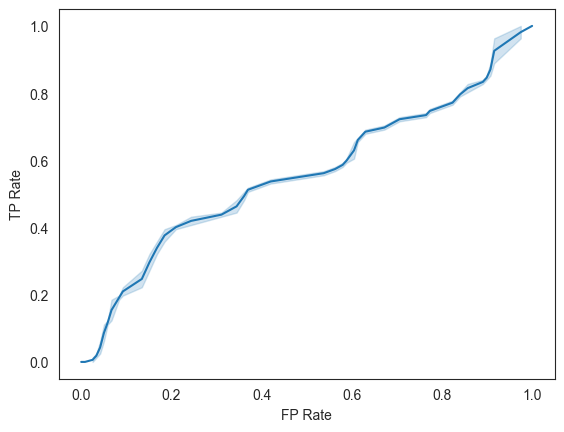

In [17]:
# Apply UMAP first [ / 4 marks]

reducer = umap.UMAP(n_neighbors=2,              # Number of neareast neighbours to use. 
                    n_components=10,              # Number of components. UMAP is robust to larger values
                    metric='cosine',          # Metric to use.
                    n_epochs=1000,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.25,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    low_memory=False,             # Run slower, but with less memory.
                    n_jobs=-1,       
                    init='random',
                    verbose=False                # Verbosity
                   )

reducer.fit(TfIDF_train)
Xtrain = reducer.transform(TfIDF_train)

#Train and test using model LogisticRegressionCV [ /4 marks]

log_model.fit(Xtrain, y_train)

Xtest = reducer.transform(TfIDF_test)

# Plot ROC curve and compute AUC score [ /4 marks]

probs = log_model.predict_proba(Xtest)

fpr1, tpr1, _ = roc_curve(y_test, probs[:,1], pos_label=log_model.classes_[1]) 

print(auc(fpr1,tpr1).round(3))

# Create and show the plot

ax =sns.lineplot(x=fpr1,y=tpr1)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")

### Question 2.4 [ /8 marks]
**Written Question:** Compare the performance of the three models. Which one is the best. [ / 2 marks] 

**Your Answer:** The best model seems to be the logistic regression model, since it has the highest AUC.